In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
import re
import pymorphy2
import string
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.utils import shuffle, resample
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Bidirectional, Dropout, GRU, SimpleRNN, GlobalMaxPooling1D
from keras import metrics
from keras import regularizers
from keras.utils import plot_model
from keras.optimizers import Adam, SGD
from keras.metrics import Precision, Recall

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## **Предобработка**

In [ ]:
# читаем данные из файла
f = '/content/drive/MyDrive/NLP/train_data_exam_1.xlsx'
df = pd.read_excel(f, 0)  
print('Dataset size', df.shape)
num_rows, num_feature = df.shape

print('row number: ', num_rows)
print('feature number: ', num_feature)
print()
print('names of features: ', list(df))

print('-------------------')
print('full data loaded')
print('-------------------')

Dataset size (18779, 2)
row number:  18779
feature number:  2

names of features:  ['original_data', 'score']
-------------------
full data loaded
-------------------


In [5]:
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
stop = set(stopwords.words("russian") + list(string.punctuation))

lemm_data = []
y_data = []
morph = pymorphy2.MorphAnalyzer()

for i in tqdm(range(num_rows)):

    s = str(df['original_data'][i])
    s1 = re.sub(r"[,.?“/!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`)(]", '', s)
    word_list = nltk.word_tokenize(s1)
    for j in range(0,len(word_list)):
        word_list[j] = morph.parse(word_list[j])[0].normal_form
    word_list = [w for w in word_list if not w in stop]  
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    lemm_data.append(lemmatized_output)
    y_data.append(word_list)
    
print('Lematization is over')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 18779/18779 [15:11<00:00, 20.60it/s]

Lematization is over


In [ ]:
len(y_data)

18779

In [ ]:
df["processed_data"] = lemm_data

In [ ]:
#  выделим строки с определеными классами
neut_df= df[df['score'] == 0]
neg_df= df[df['score'] == -1]
pos_df= df[df['score'] == 1]
super_neg_df = df[df['score'] == -2]
super_pos_df= df[df['score'] == 2]

print(neut_df.shape)
print(neg_df.shape)
print(pos_df.shape)
print(super_neg_df.shape)
print(super_pos_df.shape)

(9795, 3)
(6468, 3)
(1206, 3)
(1060, 3)
(250, 3)


In [ ]:
major_count = 9795
neg_downsample = resample(neg_df,
             replace=True,
             n_samples=major_count,
             random_state=42)

pos_downsample = resample(pos_df,
             replace=True,
             n_samples=major_count,
             random_state=42)

super_neg_downsample = resample(super_neg_df,
             replace=True,
             n_samples=major_count,
             random_state=42)

super_pos_downsample = resample(super_pos_df,
             replace=True,
             n_samples=major_count,
             random_state=42)


In [ ]:
full_up_sample = pd.concat([super_neg_downsample, neg_downsample, neut_df, pos_downsample, super_pos_downsample])
full_up_sample = shuffle(full_up_sample, random_state = 200) 
print(full_up_sample.shape)

(48975, 3)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_up_sample['processed_data'])

X = tokenizer.texts_to_sequences(full_up_sample['processed_data'].values)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)  

max_len = 50
X_pad = pad_sequences(X, maxlen = max_len, padding='post', truncating='post') 

88972


In [ ]:
Y = pd.get_dummies(full_up_sample['score']).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, Y, test_size=0.2, random_state=42)

print('Test collection size: ', X_test.shape)
print('Training collection size: ', X_train.shape)

Test collection size:  (9795, 50)
Training collection size:  (39180, 50)


## **Модели**

In [ ]:
# LSTM
max_len = 50
embed_dim = 20
lstm_out = 50
def buildModel():     
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, input_length=max_len))
    model.add(LSTM(lstm_out, dropout = 0.5))
    model.add(Dense(5, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = buildModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            1779440   
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 1,793,895
Trainable params: 1,793,895
Non-trainable params: 0
_________________________________________________________________
None


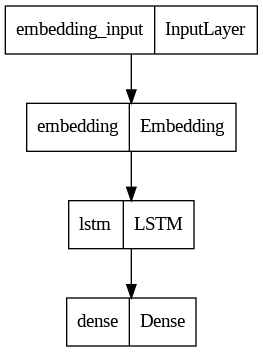

In [ ]:
plot_model(model, to_file='modelLSTM.png')

In [ ]:
model.fit(X_train, y_train, validation_split=0.05, epochs=30, batch_size=64)

Epoch 1/30
582/582 [==============================] - 56s 88ms/step - loss: 1.0097 - accuracy: 0.5534 - val_loss: 0.6842 - val_accuracy: 0.7228
Epoch 2/30
582/582 [==============================] - 40s 69ms/step - loss: 0.5636 - accuracy: 0.7787 - val_loss: 0.5572 - val_accuracy: 0.7953
Epoch 3/30
582/582 [==============================] - 37s 64ms/step - loss: 0.4568 - accuracy: 0.8364 - val_loss: 0.4968 - val_accuracy: 0.8193
Epoch 4/30
582/582 [==============================] - 37s 64ms/step - loss: 0.3983 - accuracy: 0.8629 - val_loss: 0.4735 - val_accuracy: 0.8331
Epoch 5/30
582/582 [==============================] - 37s 64ms/step - loss: 0.3590 - accuracy: 0.8789 - val_loss: 0.4615 - val_accuracy: 0.8418
Epoch 6/30
582/582 [==============================] - 36s 62ms/step - loss: 0.3350 - accuracy: 0.8866 - val_loss: 0.4682 - val_accuracy: 0.8397
Epoch 7/30
582/582 [==============================] - 36s 62ms/step - loss: 0.3149 - accuracy: 0.8918 - val_loss: 0.4552 - val_accuracy:

In [ ]:
with open('LSTM_model_final.pkl', 'wb') as fin:
    pickle.dump(model, fin)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-03-23 19:21:38           64
config.json                                    2023-03-23 19:21:38         2204
variables.h5                                   2023-03-23 19:21:39     21552752


In [ ]:
yhat_probs = model.predict(X_test)
yhat_classes = np.argmax(yhat_probs, axis=1)
rounded_labels=np.argmax(y_test, axis=1)
print(metrics.classification_report(rounded_labels, yhat_classes))

307/307 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1998
           1       0.71      0.74      0.73      1945
           2       0.81      0.56      0.66      1938
           3       0.86      0.95      0.90      1992
           4       0.94      1.00      0.97      1922

    accuracy                           0.85      9795
   macro avg       0.84      0.85      0.84      9795
weighted avg       0.84      0.85      0.84      9795



In [ ]:
# Bidirectional LSTM
max_len = 50
embed_dim = 32
lstm_out = 50
def buildModel():     
    model4 = Sequential()
    model4.add(Embedding(vocab_size, embed_dim, input_length=max_len))
    model4.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model4.add(MaxPooling1D(pool_size=2))
    model4.add(Bidirectional(LSTM(32)))
    model4.add(Dropout(0.4))
    model4.add(Dense(5, activation='softmax')) 
    model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model4
model4 = buildModel()
print(model4.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            2847104   
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                

In [ ]:
batch_size = 64 
epochs=20
history = model4.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
613/613 [==============================] - 52s 84ms/step - loss: 0.4875 - accuracy: 0.8290 - val_loss: 0.4609 - val_accuracy: 0.8312
Epoch 2/20
613/613 [==============================] - 51s 84ms/step - loss: 0.3673 - accuracy: 0.8803 - val_loss: 0.4345 - val_accuracy: 0.8419
Epoch 3/20
613/613 [==============================] - 48s 79ms/step - loss: 0.3173 - accuracy: 0.8943 - val_loss: 0.4311 - val_accuracy: 0.8484
Epoch 4/20
613/613 [==============================] - 59s 96ms/step - loss: 0.2875 - accuracy: 0.8991 - val_loss: 0.4434 - val_accuracy: 0.8556
Epoch 5/20
613/613 [==============================] - 50s 82ms/step - loss: 0.2642 - accuracy: 0.9032 - val_loss: 0.4500 - val_accuracy: 0.8426
Epoch 6/20
613/613 [==============================] - 48s 79ms/step - loss: 0.2533 - accuracy: 0.9039 - val_loss: 0.4700 - val_accuracy: 0.8485
Epoch 7/20
613/613 [==============================] - 50s 82ms/step - loss: 0.2416 - accuracy: 0.9065 - val_loss: 0.5078 - val_accuracy:

In [ ]:
yhat_probs2 = model4.predict(X_test, verbose=0)
yhat_classes2 = np.argmax(yhat_probs2, axis=1)
rounded_labels2=np.argmax(y_test, axis=1)
print(metrics.classification_report(rounded_labels2, yhat_classes2))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1998
           1       0.73      0.75      0.74      1945
           2       0.82      0.59      0.69      1938
           3       0.88      0.95      0.92      1992
           4       0.94      1.00      0.97      1922

    accuracy                           0.86      9795
   macro avg       0.85      0.85      0.85      9795
weighted avg       0.85      0.86      0.85      9795



In [ ]:
# GRU
embedding = Embedding(vocab_size, embed_dim, input_length=max_len)

model2 = Sequential()
model2.add(embedding)
model2.add(GRU(units=16, return_sequences=True))
model2.add(GRU(units=8))
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate = 1e-3),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 20)            1779440   
                                                                 
 gru_2 (GRU)                 (None, 50, 16)            1824      
                                                                 
 gru_3 (GRU)                 (None, 8)                 624       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                                 
Total params: 1,781,933
Trainable params: 1,781,933
Non-trainable params: 0
_________________________________________________________________


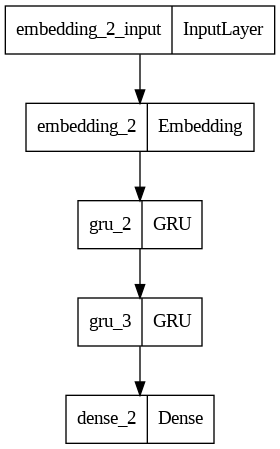

In [ ]:
plot_model(model2, to_file='modelGRU.png')

In [ ]:
model2.fit(X_train, y_train, validation_split=0.05, epochs=30, batch_size=64)

Epoch 1/30
582/582 [==============================] - 130s 196ms/step - loss: 0.4434 - accuracy: 0.4256 - val_loss: 0.3295 - val_accuracy: 0.6483
Epoch 2/30
582/582 [==============================] - 83s 143ms/step - loss: 0.2699 - accuracy: 0.7524 - val_loss: 0.2367 - val_accuracy: 0.7856
Epoch 3/30
582/582 [==============================] - 88s 150ms/step - loss: 0.1946 - accuracy: 0.8508 - val_loss: 0.2057 - val_accuracy: 0.8096
Epoch 4/30
582/582 [==============================] - 64s 110ms/step - loss: 0.1570 - accuracy: 0.8815 - val_loss: 0.1953 - val_accuracy: 0.8183
Epoch 5/30
582/582 [==============================] - 70s 120ms/step - loss: 0.1371 - accuracy: 0.8935 - val_loss: 0.1834 - val_accuracy: 0.8331
Epoch 6/30
582/582 [==============================] - 62s 106ms/step - loss: 0.1254 - accuracy: 0.9009 - val_loss: 0.1823 - val_accuracy: 0.8382
Epoch 7/30
582/582 [==============================] - 55s 94ms/step - loss: 0.1179 - accuracy: 0.9053 - val_loss: 0.1781 - val_ac

In [ ]:
yhat_probs2 = model2.predict(X_test, verbose=0)
yhat_classes2 = np.argmax(yhat_probs2, axis=1)
rounded_labels2=np.argmax(y_test, axis=1)
print(metrics.classification_report(rounded_labels2, yhat_classes2))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1998
           1       0.73      0.73      0.73      1945
           2       0.78      0.59      0.67      1938
           3       0.88      0.95      0.91      1992
           4       0.93      1.00      0.97      1922

    accuracy                           0.85      9795
   macro avg       0.84      0.85      0.84      9795
weighted avg       0.84      0.85      0.84      9795



In [ ]:
with open('GNU_model_final.pkl', 'wb') as fin:
    pickle.dump(model2, fin)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......gru
.........cell
............vars
...............0
...............1
...............2
.........vars
......gru_1
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-03-22 19:06:27           64
config.json                                    2023-03-22 19:06:27         3278
variables.h5                                   2023-03-22 19:06:27      7152088


In [ ]:
# Другая Bidirectional LSTM
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(vocab_size, embed_dim, input_length=max_len))
bi_lstm_model.add(Bidirectional(LSTM(lstm_out,
                                     activation='tanh',
                                     return_sequences=False)))
bi_lstm_model.add(Dense(5, activation='sigmoid'))
 
# Printing model summary
print(bi_lstm_model.summary())
 
# Compiling model summary
bi_lstm_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 20)            1779440   
                                                                 
 bidirectional (Bidirectiona  (None, 100)              28400     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 5)                 505       
                                                                 
Total params: 1,808,345
Trainable params: 1,808,345
Non-trainable params: 0
_________________________________________________________________
None


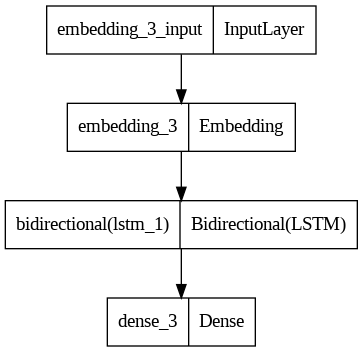

In [ ]:
plot_model(bi_lstm_model, to_file='modelBidir.png')

In [ ]:
bi_lstm_model.fit(X_train, y_train, validation_split=0.05, epochs=30, batch_size=64)

Epoch 1/30
582/582 [==============================] - 68s 108ms/step - loss: 0.3422 - accuracy: 0.5516 - val_loss: 0.2163 - val_accuracy: 0.7611
Epoch 2/30
582/582 [==============================] - 61s 105ms/step - loss: 0.1862 - accuracy: 0.8106 - val_loss: 0.1848 - val_accuracy: 0.8234
Epoch 3/30
582/582 [==============================] - 58s 100ms/step - loss: 0.1440 - accuracy: 0.8711 - val_loss: 0.1738 - val_accuracy: 0.8367
Epoch 4/30
582/582 [==============================] - 59s 101ms/step - loss: 0.1212 - accuracy: 0.8933 - val_loss: 0.1738 - val_accuracy: 0.8392
Epoch 5/30
582/582 [==============================] - 58s 99ms/step - loss: 0.1098 - accuracy: 0.9006 - val_loss: 0.1702 - val_accuracy: 0.8412
Epoch 6/30
582/582 [==============================] - 57s 98ms/step - loss: 0.1032 - accuracy: 0.9025 - val_loss: 0.1772 - val_accuracy: 0.8407
Epoch 7/30
582/582 [==============================] - 58s 100ms/step - loss: 0.0978 - accuracy: 0.9048 - val_loss: 0.1800 - val_accu

In [ ]:
with open('LSTM_Bi_model.pkl', 'wb') as fin:
    pickle.dump(bi_lstm_model, fin)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                             

In [ ]:
yhat_probs_bi = bi_lstm_model.predict(X_test, verbose=0)
yhat_classes_bi = np.argmax(yhat_probs_bi, axis=1)
rounded_labels_bi=np.argmax(y_test, axis=1)
print(metrics.classification_report(rounded_labels_bi, yhat_classes_bi))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1998
           1       0.70      0.76      0.73      1945
           2       0.81      0.56      0.66      1938
           3       0.90      0.95      0.92      1992
           4       0.94      1.00      0.97      1922

    accuracy                           0.85      9795
   macro avg       0.85      0.85      0.84      9795
weighted avg       0.85      0.85      0.84      9795



In [ ]:
# Попробуем какую-нибудь CNN
embedding_dim = 128
sequence_length = max_len
vocab_size = 88972
modelCNN = Sequential()
modelCNN.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length,
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

modelCNN.add(Conv1D(1024,3, activation='relu',
                                 kernel_regularizer = regularizers.l2(0.0005),
                                 bias_regularizer = regularizers.l2(0.0005)))                               
modelCNN.add(Conv1D(512,3, activation='relu',
                                 kernel_regularizer = regularizers.l2(0.0005),
                                 bias_regularizer = regularizers.l2(0.0005))) 
modelCNN.add(Conv1D(256,3, activation='relu',
                                 kernel_regularizer = regularizers.l2(0.0005),
                                 bias_regularizer = regularizers.l2(0.0005))) 

modelCNN.add(GlobalMaxPooling1D())

modelCNN.add(Dropout(0.5))

modelCNN.add(Dense(5, activation='sigmoid',
                                kernel_regularizer=regularizers.l2(0.001),
                                bias_regularizer=regularizers.l2(0.001),))

In [ ]:
lr = 0.001
modelCNN.summary()
modelCNN.compile(loss='categorical_crossentropy', 
              optimizer = Adam(learning_rate = lr),
              metrics=['accuracy',Precision(),Recall()])


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 38, 128)           11388416  
                                                                 
 conv1d_18 (Conv1D)          (None, 36, 1024)          394240    
                                                                 
 conv1d_19 (Conv1D)          (None, 34, 512)           1573376   
                                                                 
 conv1d_20 (Conv1D)          (None, 32, 256)           393472    
                                                                 
 global_max_pooling1d_6 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
epochs = 50
batch = 128

history = modelCNN.fit(X_train, y_train, epochs=epochs, verbose=1,
                    batch_size=batch,
                    validation_data = (X_test, y_test))

Epoch 1/50
307/307 [==============================] - 14s 32ms/step - loss: 1.5329 - accuracy: 0.4773 - precision_6: 0.2831 - recall_6: 0.8940 - val_loss: 1.0856 - val_accuracy: 0.6084 - val_precision_6: 0.2950 - val_recall_6: 0.9896
Epoch 2/50
307/307 [==============================] - 9s 30ms/step - loss: 0.9906 - accuracy: 0.6744 - precision_6: 0.3234 - recall_6: 0.9807 - val_loss: 0.9153 - val_accuracy: 0.7212 - val_precision_6: 0.3481 - val_recall_6: 0.9801
Epoch 3/50
307/307 [==============================] - 9s 30ms/step - loss: 0.8872 - accuracy: 0.7290 - precision_6: 0.3447 - recall_6: 0.9791 - val_loss: 0.9018 - val_accuracy: 0.7180 - val_precision_6: 0.3742 - val_recall_6: 0.9658
Epoch 4/50
307/307 [==============================] - 8s 28ms/step - loss: 0.8192 - accuracy: 0.7608 - precision_6: 0.3588 - recall_6: 0.9790 - val_loss: 0.8058 - val_accuracy: 0.7666 - val_precision_6: 0.3793 - val_recall_6: 0.9802
Epoch 5/50
307/307 [==============================] - 9s 28ms/step 

In [ ]:
with open('CNN_model43.pkl', 'wb') as fin:
    pickle.dump(modelCNN, fin)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv1d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......global_max_pooling1d
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......precision
.........vars
............0
............1
......recall
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified   

In [ ]:
# RNN
embed_dim = 20

RNNmodel = Sequential()
RNNmodel.add(Embedding(vocab_size, embed_dim, input_length=max_len))
RNNmodel.add(Bidirectional(SimpleRNN(50)))
RNNmodel.add(Dense(5, activation='sigmoid'))
 
# Printing model summary
print(RNNmodel.summary())
 
# Compiling model summary
RNNmodel.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 20)            1779440   
                                                                 
 bidirectional_2 (Bidirectio  (None, 100)              7100      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 5)                 505       
                                                                 
Total params: 1,787,045
Trainable params: 1,787,045
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
plot_model(RNNmodel, to_file='modelRNN.png')

In [ ]:
RNNmodel.fit(X_train, y_train, validation_split=0.05, epochs=20, batch_size=64)

Epoch 1/20
582/582 [==============================] - 44s 67ms/step - loss: 0.7833 - accuracy: 0.6852 - val_loss: 0.5100 - val_accuracy: 0.8142
Epoch 2/20
582/582 [==============================] - 46s 79ms/step - loss: 0.3884 - accuracy: 0.8664 - val_loss: 0.4509 - val_accuracy: 0.8315
Epoch 3/20
582/582 [==============================] - 41s 71ms/step - loss: 0.3073 - accuracy: 0.8939 - val_loss: 0.4493 - val_accuracy: 0.8418
Epoch 4/20
582/582 [==============================] - 40s 69ms/step - loss: 0.2756 - accuracy: 0.8997 - val_loss: 0.4500 - val_accuracy: 0.8428
Epoch 5/20
582/582 [==============================] - 36s 62ms/step - loss: 0.2591 - accuracy: 0.9026 - val_loss: 0.4672 - val_accuracy: 0.8464
Epoch 6/20
582/582 [==============================] - 36s 61ms/step - loss: 0.2482 - accuracy: 0.9039 - val_loss: 0.4516 - val_accuracy: 0.8530
Epoch 7/20
582/582 [==============================] - 38s 66ms/step - loss: 0.2383 - accuracy: 0.9060 - val_loss: 0.4799 - val_accuracy:

In [ ]:
with open('RNN_model38.pkl', 'wb') as fin:
    pickle.dump(RNNmodel, fin)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                             

In [ ]:
yhat_probs_RNN = RNNmodel.predict(X_test, verbose=0)
yhat_classes_RNN = np.argmax(yhat_probs_RNN, axis=1)
rounded_labels=np.argmax(y_test, axis=1)
print(metrics.classification_report(rounded_labels, yhat_classes_RNN))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1998
           1       0.72      0.67      0.69      1945
           2       0.74      0.65      0.69      1938
           3       0.90      0.94      0.92      1992
           4       0.93      1.00      0.97      1922

    accuracy                           0.85      9795
   macro avg       0.84      0.85      0.84      9795
weighted avg       0.84      0.85      0.84      9795



# **ТЕСТИРОВАНИЕ**

In [ ]:
# читаем данные из файла
f = '/content/drive/MyDrive/NLP/test_data_exam_1.xlsx'
df1 = pd.read_excel(f, 0)  
print('Dataset size', df1.shape)
num_rows, num_feature = df1.shape

print('row number: ', num_rows)
print('feature number: ', num_feature)
print()
print('names of features: ', list(df1))

print('-------------------')
print('full data loaded')
print('-------------------')

Dataset size (8048, 2)
row number:  8048
feature number:  2

names of features:  ['original_data', 'score']
-------------------
full data loaded
-------------------


In [7]:
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
y_data1 = []
lemm_data1 = []
morph = pymorphy2.MorphAnalyzer()
stop = set(stopwords.words("russian") + list(string.punctuation))

for i in tqdm(range(num_rows)):

    s2 = str(df1['original_data'][i])
    s12 = re.sub(r"[,.?“/!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`)(]", '', s2)
    word_list1 = nltk.word_tokenize(s12)
    for j in range(0,len(word_list1)):
        word_list1[j] = morph.parse(word_list1[j])[0].normal_form
    word_list1 = [w for w in word_list1 if not w in stop]  
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list1])
    lemm_data1.append(lemmatized_output)
    y_data1.append(word_list1)
    
print('Lematization is over')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 8048/8048 [06:04<00:00, 22.09it/s]

Lematization is over


In [ ]:
df1['processed_data'] =  lemm_data1

In [ ]:
df1["processed data"] = lemm_data1

neut_df1= df1[df1['score'] == 0]
neg_df1= df1[df1['score'] == -1]
pos_df1= df1[df1['score'] == 1]
super_neg_df1 = df1[df1['score'] == -2]
super_pos_df1= df1[df1['score'] == 2]

print(neut_df1.shape)
print(neg_df1.shape)
print(pos_df1.shape)
print(super_neg_df1.shape)
print(super_pos_df1.shape)

(4199, 3)
(2747, 3)
(524, 3)
(473, 3)
(105, 3)


In [ ]:
print('neg_dataset before sampling: ', neg_df1.shape)

neg_downsample = resample(neg_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('neg_dataset after sampling: ', neg_downsample.shape)

print('pos_dataset before sampling: ', pos_df1.shape)

pos_downsample = resample(pos_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('pos_dataset after sampling: ', pos_downsample.shape)

print('super_neg_dataset before sampling: ', super_neg_df1.shape)

super_neg_downsample = resample(super_neg_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('super_neg_dataset after sampling: ', super_neg_downsample.shape)

print('super_pos_dataset before sampling: ', super_pos_df1.shape)

super_pos_downsample = resample(super_pos_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('neg_dataset after sampling: ', super_pos_downsample.shape)

neg_dataset before sampling:  (2747, 3)
neg_dataset after sampling:  (4199, 3)
pos_dataset before sampling:  (524, 3)
pos_dataset after sampling:  (4199, 3)
super_neg_dataset before sampling:  (473, 3)
super_neg_dataset after sampling:  (4199, 3)
super_pos_dataset before sampling:  (105, 3)
neg_dataset after sampling:  (4199, 3)


In [ ]:
full_up_sample1 = pd.concat([super_neg_downsample, neg_downsample, neut_df1, pos_downsample, super_pos_downsample])
print(full_up_sample1.shape)

(20995, 3)


In [ ]:
X1 = tokenizer.texts_to_sequences(full_up_sample1['processed data'].values)
max_len = 50
X1 = pad_sequences(X1, maxlen = max_len)
Y1 = pd.get_dummies(full_up_sample1['score']).values

In [ ]:
with open("/content/drive/MyDrive/NLP/LSTM_model_final.pkl", "rb") as f:
    LSTM_model_final = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-22 09:44:14           64
config.json                                    2023-03-22 09:44:14         2204
variables.h5                                   2023-03-22 09:44:14     21552752
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars


In [ ]:
yhat_probs = LSTM_model_final.predict(X1)
yhat_classes = np.argmax(yhat_probs, axis=1)
rounded_labels=np.argmax(Y1, axis=1)
print(metrics.classification_report(rounded_labels, yhat_classes))

657/657 [==============================] - 6s 8ms/step
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      4199
           1       0.61      0.64      0.63      4199
           2       0.55      0.71      0.62      4199
           3       0.80      0.75      0.78      4199
           4       0.92      0.81      0.86      4199

    accuracy                           0.73     20995
   macro avg       0.75      0.73      0.73     20995
weighted avg       0.75      0.73      0.73     20995



In [ ]:
with open("/content/drive/MyDrive/NLP/GNU_model_final.pkl", "rb") as f:
    GNU_model = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-22 19:06:26           64
config.json                                    2023-03-22 19:06:26         3278
variables.h5                                   2023-03-22 19:06:26      7152088
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......gru
.........cell
............vars
...............0
...............1
...............2
.........vars
......gru_1
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars


In [ ]:
yhat_probsGNU =  GNU_model.predict(X1)
yhat_classesGNU = np.argmax(yhat_probsGNU, axis=1)
rounded_labels=np.argmax(Y1, axis=1)
print(metrics.classification_report(rounded_labels, yhat_classesGNU))

657/657 [==============================] - 7s 10ms/step
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      4199
           1       0.61      0.62      0.62      4199
           2       0.55      0.69      0.61      4199
           3       0.79      0.75      0.77      4199
           4       0.92      0.82      0.87      4199

    accuracy                           0.72     20995
   macro avg       0.74      0.72      0.73     20995
weighted avg       0.74      0.72      0.73     20995



In [ ]:
with open("/content/drive/MyDrive/NLP/LSTM_Bi_model.pkl", "rb") as f:
    LSTM_Bi_model = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-22 20:08:14           64
config.json                                    2023-03-22 20:08:14         2351
variables.h5                                   2023-03-22 20:08:14     21738776
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........

In [ ]:
yhat_probsBI = LSTM_Bi_model.predict(X1)
yhat_classesBI = np.argmax(yhat_probsBI, axis=1)
rounded_labels=np.argmax(Y1, axis=1)
print(metrics.classification_report(rounded_labels, yhat_classesBI))

657/657 [==============================] - 10s 12ms/step
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      4199
           1       0.57      0.66      0.61      4199
           2       0.57      0.67      0.62      4199
           3       0.80      0.75      0.77      4199
           4       0.92      0.81      0.87      4199

    accuracy                           0.72     20995
   macro avg       0.74      0.72      0.73     20995
weighted avg       0.74      0.72      0.73     20995



In [ ]:
yhat_probsBI = bi_lstm_model.predict(X1)
yhat_classesBI = np.argmax(yhat_probsBI, axis=1)
rounded_labels=np.argmax(Y1, axis=1)
print(metrics.classification_report(rounded_labels, yhat_classesBI))

In [ ]:
with open("/content/drive/MyDrive/NLP/CNN_model43.pkl", "rb") as f:
    CNN_model = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-22 22:29:30    165049896
config.json                                    2023-03-22 22:29:28         4665
metadata.json                                  2023-03-22 22:29:28           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv1d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......global_max_pooling1d
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......precision
.........vars
............0
............1
......recall
.........vars
............0
........

In [ ]:
yhat_probs = CNN_model.predict(X1)
yhat_classes = np.argmax(yhat_probs, axis=1)
rounded_labels=np.argmax(Y1, axis=1)
print(metrics.classification_report(rounded_labels, yhat_classes))

657/657 [==============================] - 73s 111ms/step
              precision    recall  f1-score   support

           0       0.50      0.24      0.32      4199
           1       0.30      0.38      0.33      4199
           2       0.26      0.64      0.37      4199
           3       0.47      0.23      0.30      4199
           4       0.73      0.20      0.31      4199

    accuracy                           0.34     20995
   macro avg       0.45      0.34      0.33     20995
weighted avg       0.45      0.34      0.33     20995



In [ ]:
with open("/content/drive/MyDrive/NLP/RNN_model38.pkl", "rb") as f:
    RNN_model = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-22 23:13:08     21482680
config.json                                    2023-03-22 23:13:08         2283
metadata.json                                  2023-03-22 23:13:08           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........

In [ ]:
yhat_probs = RNN_model.predict(X1)
yhat_classes = np.argmax(yhat_probs, axis=1)
rounded_labels=np.argmax(Y1, axis=1)
print(metrics.classification_report(rounded_labels, yhat_classes))

657/657 [==============================] - 7s 11ms/step
              precision    recall  f1-score   support

           0       0.68      0.30      0.41      4199
           1       0.38      0.48      0.43      4199
           2       0.29      0.69      0.41      4199
           3       0.45      0.29      0.35      4199
           4       0.91      0.26      0.40      4199

    accuracy                           0.40     20995
   macro avg       0.54      0.40      0.40     20995
weighted avg       0.54      0.40      0.40     20995

